In [ ]:
!pip install transformers sentence_transformers datasets hdbscan bertopic umap-learn openai datamapplot

In [ ]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

In [ ]:
data = load_dataset("maartengr/arxiv_nlp")["train"]
abstracts = data["Abstracts"]
titles = data["Titles"]

## Embedding Model

In [ ]:
model = SentenceTransformer('thenlper/gte-small')
embeddings = model.encode(abstracts, show_progress_bar=True)

In [ ]:
embeddings.shape

(44949, 384)

## Dimentionality Reduction using UMAP

In [ ]:
from umap.umap_ import UMAP
# We reduce the input embeddings from 384 dimensions to 5 dimensions
umap_model = UMAP( n_components=5, min_dist=0.0, metric='cosine',random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)




/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


## Finding Clusters using HDBSCAN

In [ ]:
from hdbscan import HDBSCAN
# We fit the model and extract the clusters
hdbscan_model = HDBSCAN( min_cluster_size=50, metric="euclidean",cluster_selection_method="eom").fit(reduced_embeddings)
clusters = hdbscan_model.labels_

In [ ]:
from bertopic import BERTopic
# Train our model with our previously defined models
topic_model = BERTopic(embedding_model=model, umap_model=umap_model, hdbscan_model=hdbscan_model, verbose=True).fit(abstracts, embeddings)


2024-10-16 16:55:39,070 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-10-16 16:56:44,558 - BERTopic - Dimensionality - Completed ✓
2024-10-16 16:56:44,561 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-10-16 16:56:46,756 - BERTopic - Cluster - Completed ✓
2024-10-16 16:56:46,780 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-10-16 16:56:53,825 - BERTopic - Representation - Completed ✓


In [ ]:
topic_model.get_topic_info()

Topic  Count                                          Name  \
0       -1  14325                              -1_the_of_and_to   
1        0   2114                0_question_qa_answer_questions   
2        1   2075                  1_speech_asr_recognition_end   
3        2   1192         2_medical_clinical_biomedical_patient   
4        3    909              3_translation_nmt_machine_neural   
..     ...    ...                                           ...   
148    147     53     147_prompt_prompts_optimization_prompting   
149    148     52        148_coherence_discourse_paragraph_text   
150    149     52          149_counseling_mental_therapy_health   
151    150     51  150_diffusion_generation_autoregressive_text   
152    151     50   151_opinion_reviews_summaries_summarization   

                                        Representation  \
0    [the, of, and, to, in, we, language, for, that...   
1    [question, qa, answer, questions, answering, a...   
2    [speech, asr, recognition, end, acoustic, spea...   
3    [medical, clinical, biomedical, patient, notes...   
4    [translation, nmt, machine, neural, bleu, engl...   
..                                                 ...   
148  [prompt, prompts, optimization, prompting, llm...   
149  [coherence, discourse, paragraph, text, cohesi...   
150  [counseling, mental, therapy, health, psychoth...   
151  [diffusion, generation, autoregressive, text, ...   
152  [opinion, reviews, summaries, summarization, r...   

                                   Representative_Docs  
0    [  We study the problem of building text class...  
1    [  In multi-hop QA, answering complex question...  
2    [  We introduce the Universal Speech Model (US...  
3    [  Clinical text provides essential informatio...  
4    [  Neural machine translation~(NMT) is ineffec...  
..                                                 ...  
148  [  Prompt optimization aims to find the best p...  
149  [  While there has been significant progress t...  
150  [  Mental health care poses an increasingly se...  
151  [  Diffusion models have achieved great succes...  
152  [  When faced with a large number of product r...  

[153 rows x 5 columns]

In [ ]:
topic_model.get_topic(0)

[('question', 0.02194817482363572),
 ('qa', 0.016528096692201028),
 ('answer', 0.01646242138694385),
 ('questions', 0.016439633707498843),
 ('answering', 0.015251123923490635),
 ('answers', 0.010198054270247945),
 ('retrieval', 0.00957232274465297),
 ('comprehension', 0.008074006002320675),
 ('reading', 0.00750035197154994),
 ('hop', 0.006446690650992912)]

In [ ]:
topic_model.find_topics("topic modeling")

([21, -1, 27, 33, 2],
 [0.95478904, 0.91128266, 0.9082118, 0.9053225, 0.90511835])

In [ ]:
topic_model.get_topic(19)

[('word', 0.03801937019938523),
 ('embeddings', 0.02891976685312965),
 ('embedding', 0.021761971759590767),
 ('vectors', 0.016165683604574127),
 ('words', 0.014626290138520235),
 ('vector', 0.012715749352599986),
 ('representations', 0.011563897908421826),
 ('word2vec', 0.011004165207570823),
 ('similarity', 0.009631170825775519),
 ('glove', 0.008707833529440394)]

In [ ]:
topic_model.topics_[titles.index("BERTopic: Neural topic modeling with a class-based TF-IDF procedure")]

21

In [ ]:
umap_model = UMAP( n_components=2, min_dist=0.0, metric='cosine',random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

In [ ]:
fig = topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, width=1200, hide_annotations=True)
fig.update_layout(font=dict(size=16))

## Fine Tune using reranker

In [15]:
from copy import deepcopy
import pandas as pd
original_topics = deepcopy(topic_model.topic_representations_)

## Building a function to compare between old topic model and the new model.

In [16]:
def topic_differences(model, original_topics, nr_topics=5):
  df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
  for topic in range(nr_topics):
    og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
    new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
    df.loc[len(df)] = [topic, og_words, new_words]
  return df

## KeyBERTInspired for diverse in topics

In [17]:
from bertopic.representation import KeyBERTInspired

representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

In [18]:
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | qa | answer | questions | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | notes   
3      3        translation | nmt | machine | neural | bleu   
4      4  summarization | summaries | summary | abstract...   

                                             Updated  
0  answering | questions | comprehension | retrie...  
1      language | phonetic | speech | spoken | voice  
2             nlp | clinical | ehr | ehrs | language  
3  translating | translation | translate | transl...  
4  summarization | summarizers | summaries | summ...

In [19]:
from bertopic.representation import MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance()
topic_model.update_topics(abstracts, representation_model=representation_model)

In [20]:
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | qa | answer | questions | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | notes   
3      3        translation | nmt | machine | neural | bleu   
4      4  summarization | summaries | summary | abstract...   

                                             Updated  
0  answering | retrieval | comprehension | readin...  
1           speech | asr | audio | model | automatic  
2  medical | clinical | biomedical | patient | he...  
3  translation | nmt | neural | parallel | multil...  
4  summarization | summaries | abstractive | sent...

## Using generative models to generate topics

In [21]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: '[KEYWORDS]'.
Based on the documents and keywords, what is this topic about?
"""
generator = pipeline("text2text-generation", model="google/flan-t5-small")

representation_model = TextGeneration(generator, prompt=prompt, doc_length=50, tokenizer="whitespace")
topic_model.update_topics(abstracts, representation_model=representation_model)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
100%|██████████| 153/153 [01:18<00:00,  1.96it/s]


In [22]:
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | qa | answer | questions | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | notes   
3      3        translation | nmt | machine | neural | bleu   
4      4  summarization | summaries | summary | abstract...   

                                  Updated  
0          Question answering |  |  |  |   
1  Speech-to-text translation |  |  |  |   
2                Science/Tech |  |  |  |   
3                Science/Tech |  |  |  |   
4               Summarization |  |  |  |

## Using OpenAI generator to generate topics

In [23]:
import openai
from bertopic.representation import OpenAI

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]
Based on the information above, extract a short topic label in
the following format:
topic: <short topic label>
"""

client = openai.OpenAI(api_key="Your key")
representation_model = OpenAI(client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)
topic_model.update_topics(abstracts, representation_model=representation_model)

100%|██████████| 153/153 [02:08<00:00,  1.19it/s]


In [24]:
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | qa | answer | questions | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | notes   
3      3        translation | nmt | machine | neural | bleu   
4      4  summarization | summaries | summary | abstract...   

                                             Updated  
0              Question Answering Models and Methods  
1  Enhancing Speech Recognition Models with Multi...  
2  Clinical Text Processing for Medical Entity Ex...  
3  Neural Machine Translation and System Combinat...  
4  Improving Factual Consistency in Abstractive S...

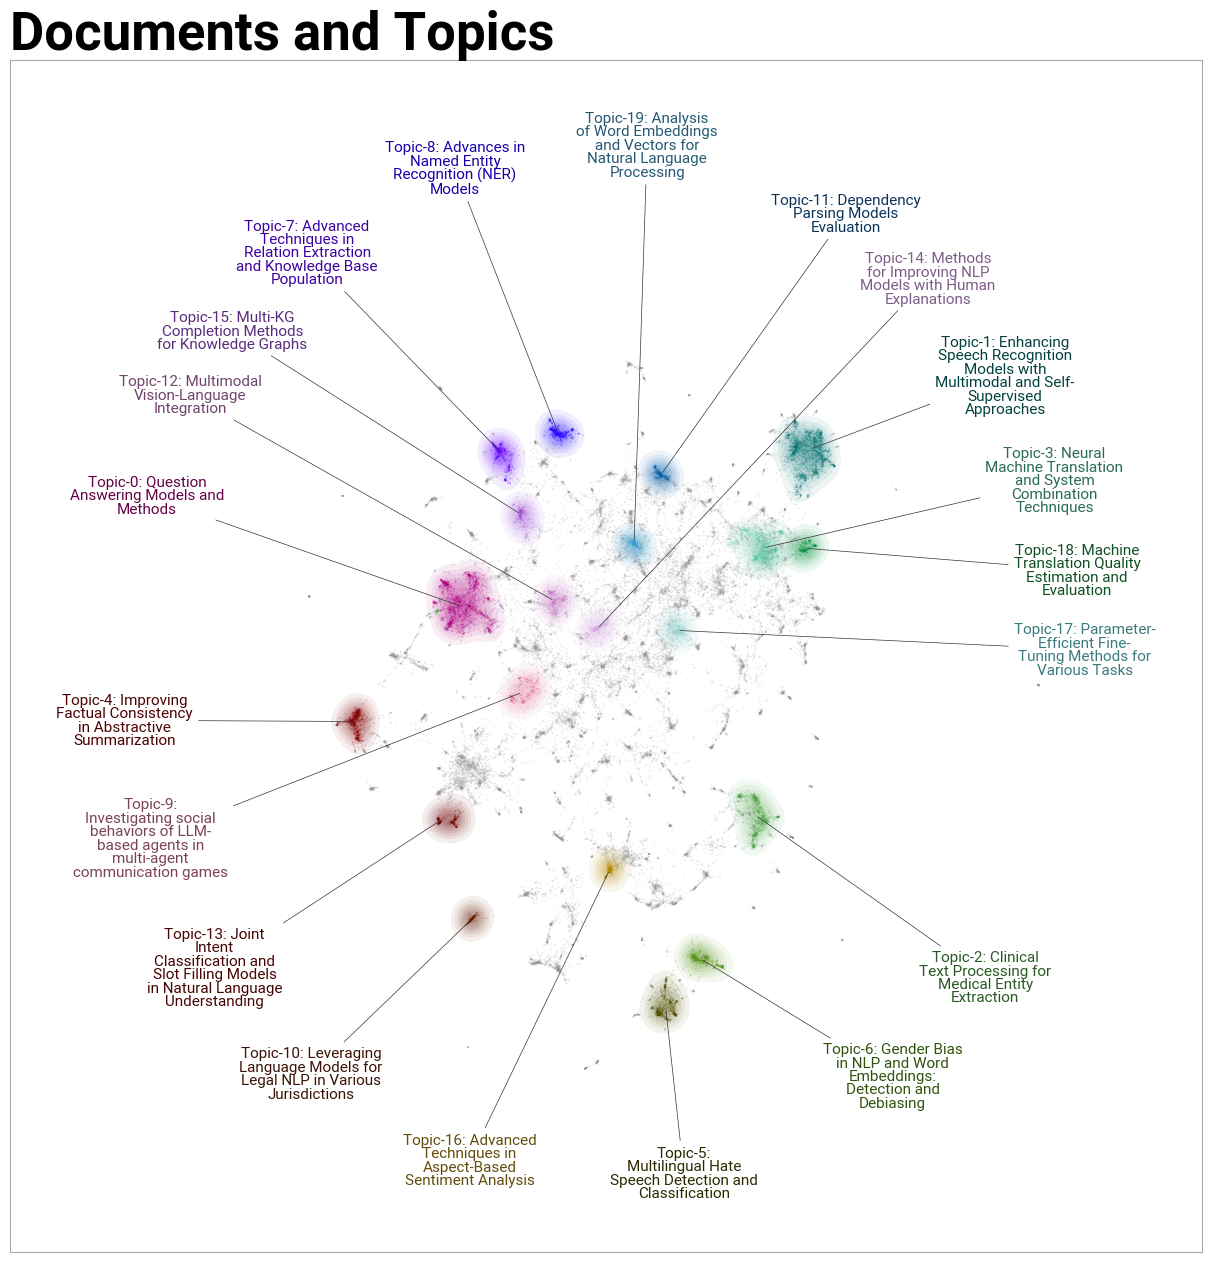

In [26]:
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200,
    label_font_size=11,
    label_wrap_width=20,
    use_medoids=True)